<a href="https://colab.research.google.com/github/AhirtonLopes/Transfer_Learning_GANs/blob/master/GAN_CIFAR10V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Uma implementação de DCGANs usando a técnica de convolução transposta e a biblioteca Keras.

- Dados

Redimensionar as imagens do CIFAR-10 entre -1 e 1.

- Gerador

Usar o inverso da convolução, chamada de convolução transposta.

Ativação de ReLU e BatchNormalization.

A entrada para o gerador é a distribuição normal z ou amostra latente (100 valores).

A última ativação é tanh.

- Discriminador

Usamos uma rede neural convolucional.

Ativação LeakyReLU e BatchNormalization.

A última ativação é sigmóide.

- Perda

binary_crossentropy

- Otimizador

Adam (lr = 0,0003, beta_1 = 0,5)
batch_size = 64
épocas = 100

In [0]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.layers import Input, Flatten, Embedding, multiply, Dropout
from keras.layers import Concatenate, GaussianNoise,Activation
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical
from keras import initializers
from keras import backend as K

Using TensorFlow backend.


In [0]:
# Carregando nosso dataset

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

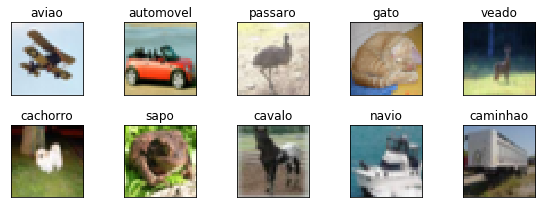

In [4]:
num_classes = len(np.unique(y_train))
class_names = ['aviao','automovel','passaro','gato','veado',
               'cachorro','sapo','cavalo','navio','caminhao']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()

In [5]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'amostras de treinamento')
print(X_test.shape[0], 'amostras de teste')

X_train shape: (50000, 32, 32, 3)
50000 amostras de treinamento
10000 amostras de teste


In [6]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)
    
# Convertendo nossos vetores de classes para representações 
# em matrizes de classe binárias

Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

# O gerador está usando a ativação de tanh, para a qual precisamos pré-processar
# os dados da imagem em um intervalo entre -1 e 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_test / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

print('X_train reshape:', X_train.shape)
print('X_test reshape:', X_test.shape)

X_train reshape: (50000, 32, 32, 3)
X_test reshape: (10000, 32, 32, 3)


In [7]:
print(X_train[0].shape)

(32, 32, 3)


In [8]:
# Espaço dimensional latente

z = Input(shape=(100,))

# Classes

labels = Input(shape=(10,))

# Rede geradora

merged_layer = Concatenate()([z, labels])

# FC: 2x2x512

generator = Dense(2*2*512, activation='relu')(merged_layer)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)
generator = Reshape((2, 2, 512))(generator)

# # Conv 1: 4x4x256

generator = Conv2DTranspose(256, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 2: 8x8x128

generator = Conv2DTranspose(128, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 3: 16x16x64

generator = Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 4: 32x32x3

generator = Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')(generator)

# generator = Model(inputs=[z, labels], outputs=out_g)

generator = Model(inputs=[z, labels], outputs=generator, name='generator')

W0705 19:32:02.351116 140392304703360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0705 19:32:02.374999 140392304703360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0705 19:32:02.384102 140392304703360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0705 19:32:02.481730 140392304703360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0705 19:32:02.666746 

In [9]:
# Sumário representativo de nosso modelo

generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 110)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2048)         227328      concatenate_1[0][0]              
__________

In [0]:
# Imagem de entrada

img_input = Input(shape=(X_train[0].shape))

# Conv 1: 16x16x64

discriminator = Conv2D(64, kernel_size=5, strides=2, padding='same')(img_input)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 2:

discriminator = Conv2D(128, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 3: 

discriminator = Conv2D(256, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 4: 

discriminator = Conv2D(512, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# FC

discriminator = Flatten()(discriminator)

# Concatenação

merged_layer = Concatenate()([discriminator, labels])
discriminator = Dense(512, activation='relu')(merged_layer)
    
# Saída

discriminator = Dense(1, activation='sigmoid')(discriminator)

discriminator = Model(inputs=[img_input, labels], outputs=discriminator, name='discriminator')

In [11]:
# Sumário representativo de nosso modelo

discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   4864        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 16, 16, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 16, 16, 64)   0           batch_normalization_5[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [12]:
# Otimizador

discriminator.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

W0705 19:32:04.096220 140392304703360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0705 19:32:04.110122 140392304703360 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
discriminator.trainable = False

label = Input(shape=(10,), name='label')
z = Input(shape=(100,), name='z')

fake_img = generator([z, label])
validity = discriminator([fake_img, label])

d_g = Model([z, label], validity, name='adversarial')

d_g.compile(Adam(lr=0.0004, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])

In [14]:
# Sumário representativo de nosso modelo

d_g.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z (InputLayer)                  (None, 100)          0                                            
__________________________________________________________________________________________________
label (InputLayer)              (None, 10)           0                                            
__________________________________________________________________________________________________
generator (Model)               (None, 32, 32, 3)    4543363     z[0][0]                          
                                                                 label[0][0]                      
__________________________________________________________________________________________________
discriminator (Model)           (None, 1)            5365121     generator[1][0]                  
          

epoch = 1/100, d_loss=0.392, g_loss=6.047                                                                                                     


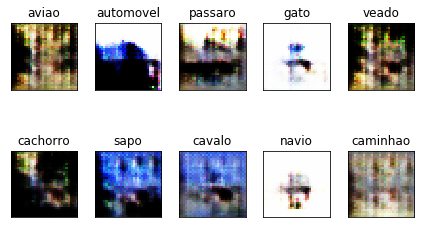

epoch = 2/100, d_loss=0.376, g_loss=2.997                                                                                                     
epoch = 3/100, d_loss=0.478, g_loss=2.329                                                                                                     
epoch = 4/100, d_loss=0.331, g_loss=3.193                                                                                                     
epoch = 5/100, d_loss=0.412, g_loss=3.695                                                                                                     
epoch = 6/100, d_loss=0.387, g_loss=3.986                                                                                                     
epoch = 7/100, d_loss=0.202, g_loss=3.703                                                                                                     
epoch = 8/100, d_loss=0.369, g_loss=1.199                                                                                                     

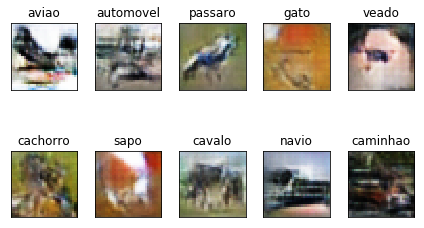

epoch = 12/100, d_loss=0.176, g_loss=3.564                                                                                                     
epoch = 13/100, d_loss=0.168, g_loss=0.283                                                                                                     


In [0]:
epochs = 100
batch_size = 32
smooth = 0.1
latent_dim = 100

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Treinamendo os pesos de nosso discriminador
        
        discriminator.trainable = True
        
        # Amostras reais
        
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        real_labels = to_categorical(y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1), num_classes=10)
        
        d_loss_real = discriminator.train_on_batch(x=[X_batch, real_labels],
                                                   y=real * (1 - smooth))
        
        # Amostras falsas
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
        X_fake = generator.predict_on_batch([z, random_labels])
        
        d_loss_fake = discriminator.train_on_batch(x=[X_fake, random_labels], y=fake)
         
        # Perda de nosso discriminador
        
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Treinando os pesos de nosso gerador
        
        discriminator.trainable = False
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_labels], y=real)
   
        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        labels = to_categorical(np.arange(0, 10).reshape(-1, 1), num_classes=10)
        
        x_fake = generator.predict([z, labels])
        x_fake = np.clip(x_fake, -1, 1)
        x_fake = (x_fake + 1) * 127
        x_fake = np.round(x_fake).astype('uint8')

        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(x_fake[k])
            plt.title(class_names[k])

        plt.tight_layout()
        plt.show()

In [0]:
# Plotando nossas métricas de avaliação do modelo

plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()